# BERT for Sequence Classification (Re-implementation)

In [ ]:
# Global variables

BATCH_SIZE = 32
MODEL_NAME = 'nlpaueb/legal-bert-small-uncased'#'bert-base-uncased'
EPOCHS = 3
EMBEDDING_SIZE = 512
NUM_CLASSES = 2

### Installation of packages

In [ ]:
!pip install transformers
!pip install torch-lr-finder

### Imports

In [ ]:
import torch
import os
from transformers import BertTokenizer
from google.colab import drive
from torch.utils.data import TensorDataset, random_split
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import numpy as np
import time
import datetime
import random
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split

### Device

In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


### Reading dataset

In [ ]:
drive.mount('/content/drive')
%cd /content/drive/MyDrive/

In [ ]:
# Funtion to read all sentences
def get_sentences(path):
    sentences= []
    for filename in os.listdir(path):
        with open(path+filename, 'r') as f:
            for sentence in f :
                sentences.append(sentence)
    return sentences

In [ ]:
# Function to read get all labels
def get_labels(path):
    all_labels = []
    for filename in os.listdir(path):
        file_labels = []
        with open(path+filename, 'r') as f:
            for label in f :
                all_labels.append(int(label))
    return all_labels

In [ ]:
# Reading sentences and labels
all_sentences = get_sentences("ToS/Sentences/")
all_labels = get_labels("ToS/Labels/")

In [ ]:
# Since unfair sentences are marked as "-1", we change them to "0" for simplicity
all_labels =  [0 if label ==-1 else label for label in all_labels]

### Bert Tokenizer

In [ ]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME, do_lower_case=True)

In [ ]:
max_len = 0

# For every sentence...
for sent in all_sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

#### Tokenize dataset

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in all_sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True,
                        max_length = 512,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(all_labels)

#### Dataset split

In [ ]:
batch_size = BATCH_SIZE

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 95-5 train-validation split.
train_idx, valid_idx = train_test_split(np.arange(len(labels)), test_size=0.05, shuffle=True, stratify=labels)

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
validation_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

### Training classification model

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels = NUM_CLASSES,   
    output_attentions = False,
    output_hidden_states = False,
)

# Tell pytorch to run this model on the GPU.
model.cuda()

### Optimizer & Learning Rate Scheduler

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8,
                )

In [ ]:
epochs = EPOCHS

total_steps = len(train_dataloader) * epochs

from torch.optim.lr_scheduler import CosineAnnealingLR
MIN_LR = 1e-5
scheduler = CosineAnnealingLR(optimizer, 600, eta_min = MIN_LR)

### Training

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
tr_metrics = []
va_metrics = []

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    train_loss = 0.0
    train_preds = []
    train_targets = []
    
    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    io_total_train_acc = 0
    io_total_train_prec = 0
    io_total_train_recall = 0
    io_total_train_f1 = 0
    io_total_valid_acc = 0
    io_total_valid_prec = 0
    io_total_valid_recall = 0
    io_total_valid_f1 = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 100 batches.
        if step % 100 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        """
        print(f'loss {loss}')
        print(f'logits {logits}')
        """
        train_preds.extend(logits.argmax(dim=1).cpu().numpy())
        train_targets.extend(batch[2].numpy())

        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

        train_acc = accuracy_score(train_targets, train_preds)
        train_precision = precision_score(train_targets, train_preds)
        train_recall = recall_score(train_targets, train_preds)
        train_f1 = f1_score(train_targets, train_preds)

        io_total_train_acc += train_acc
        io_total_train_prec += train_precision
        io_total_train_recall += train_recall
        io_total_train_f1 += train_f1

    io_avg_train_acc = io_total_train_acc / len(train_dataloader)
    io_avg_train_prec = io_total_train_prec / len(train_dataloader)
    io_avg_train_recall = io_total_train_recall / len(train_dataloader)
    io_avg_train_f1 = io_total_train_f1 / len(train_dataloader)
    print(
        f'Epoch {epoch_i+1} : \n\
        Train_acc : {io_avg_train_acc}\n\
        Train_F1 : {io_avg_train_f1}\n\
        Train_precision : {io_avg_train_prec}\n\
        Train_recall : {io_avg_train_recall}'
    )

    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    valid_preds = []
    valid_targets = []

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)
            
        loss = result.loss
        logits = result.logits

        valid_preds.extend(logits.argmax(dim=1).cpu().numpy())
        valid_targets.extend(batch[2].numpy())

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
        valid_acc = accuracy_score(valid_targets, valid_preds)
        valid_precision = precision_score(valid_targets, valid_preds)
        valid_recall = recall_score(valid_targets, valid_preds)
        valid_f1 = f1_score(valid_targets, valid_preds)

        io_total_valid_acc += valid_acc
        io_total_valid_prec += valid_precision
        io_total_valid_recall += valid_recall
        io_total_valid_f1 += valid_f1

    io_avg_valid_acc = io_total_valid_acc / len(validation_dataloader)
    io_avg_valid_prec = io_total_valid_prec / len(validation_dataloader)
    io_avg_valid_recall = io_total_valid_recall / len(validation_dataloader)
    io_avg_valid_f1 = io_total_valid_f1 / len(validation_dataloader)
    print(
            f'Epoch {epoch_i+1} : \n\
            Valid_acc : {io_avg_valid_acc}\n\
            Valid_F1 : {io_avg_valid_f1}\n\
            Valid_precision : {io_avg_valid_prec}\n\
            Valid_recall : {io_avg_valid_recall}'
          )

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Accur.': io_avg_train_acc,
            'Training F1': io_avg_train_f1,
            'Training Precision': io_avg_train_prec, 
            'Training Recall': io_avg_train_recall,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Valid. F1': io_avg_valid_f1,
            'Valid. Precision': io_avg_valid_prec, 
            'Valid. Recall': io_avg_valid_recall,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Training Accur.,Training F1,Training Precision,Training Recall,Valid. Loss,Valid. Accur.,Valid. F1,Valid. Precision,Valid. Recall,Training Time,Validation Time
epoch,,,,,,,,,,,,
1,0.23,0.89,0.20,0.48,0.13,0.15,0.92,0.73,0.81,0.67,0:02:03,0:00:02
2,0.12,0.95,0.78,0.84,0.73,0.14,0.94,0.74,0.68,0.80,0:02:03,0:00:02
3,0.09,0.97,0.85,0.89,0.81,0.13,0.95,0.85,0.84,0.86,0:02:03,0:00:02


##### Loss per epoch - Training VS Validation


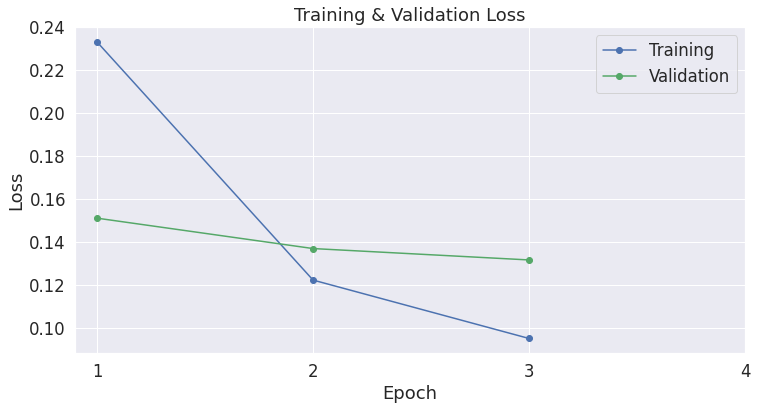

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

##### Accuracy per epoch - Training VS Validation

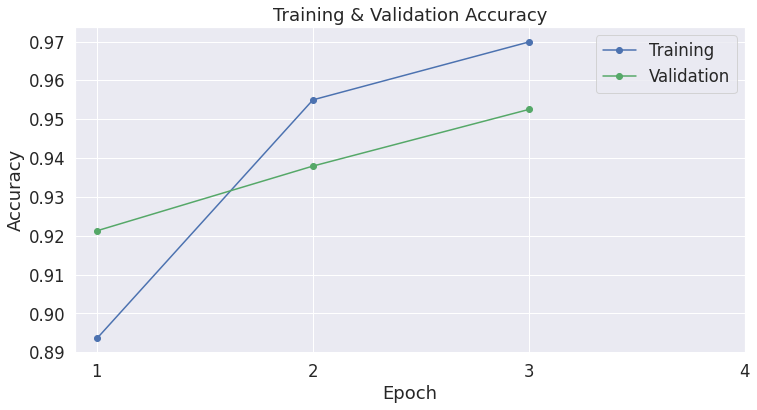

In [ ]:
# Plot the learning curve.
plt.plot(df_stats['Training Accur.'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Accur.'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

##### F1 per epoch - Training VS Validation

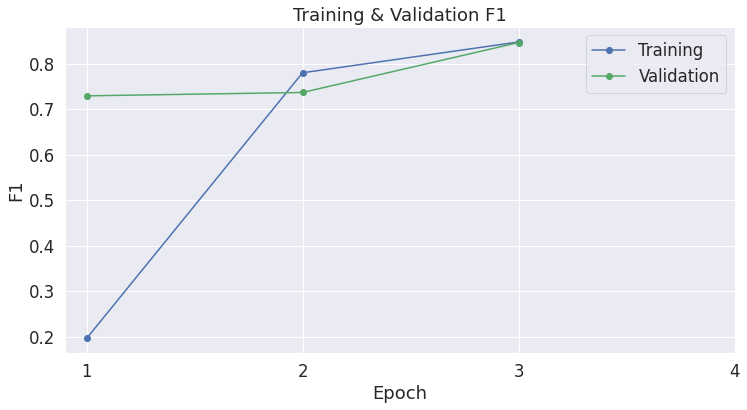

In [ ]:
# Plot the learning curve.
plt.plot(df_stats['Training F1'], 'b-o', label="Training")
plt.plot(df_stats['Valid. F1'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation F1")
plt.xlabel("Epoch")
plt.ylabel("F1")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

##### Recall per epoch - Training VS Validation

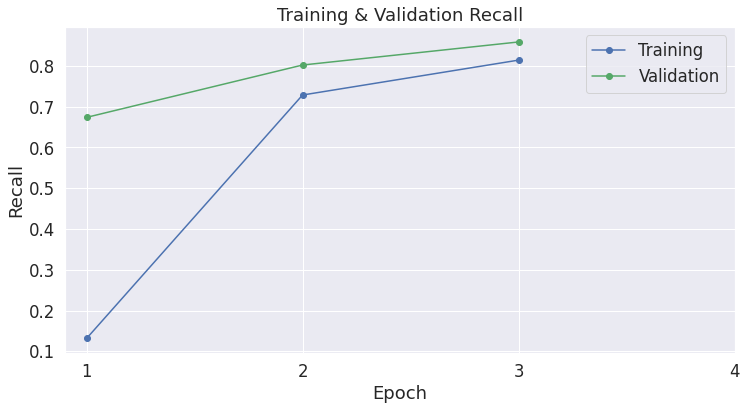

In [ ]:
# Plot the learning curve.
plt.plot(df_stats['Training Recall'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Recall'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Recall")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()